In [8]:
"""
Project: Cryptocurrency Market Analysis (CoinGecko API) + ML Extension
Author: Krish Maisuria
Date: Nov 2025
Python: 3.10+  |  Libraries: requests, json, pandas, numpy, seaborn, matplotlib, scikit-learn

Summary
-------
This script/notebook:
1) Collects real-time cryptocurrency market data from the public CoinGecko REST API (no API key).
2) Cleans and transforms the JSON payload into a Pandas DataFrame and engineers features:
   - volatility_score = |price_change_percentage_24h|
   - vol_mcap_ratio = total_volume / market_cap
   - market_cap_group = qcut-based size buckets (Small/Mid/Large/Mega)
3) Produces three visualizations (saved to images/):
   - Histogram of 24h % price change
   - Scatter: market_cap vs total_volume (log–log), colored by market_cap_group
   - Heatmap: average metrics by market_cap_group
4) (Optional) Trains and evaluates a simple Linear Regression model (scikit-learn)
   to predict 24h % price change from market_cap and total_volume; reports R²/MAE.

I/O and Reproducibility
-----------------------
- Creates folders if missing: data/, images/
- Saves raw API data to: data/raw.json
- Saves cleaned dataset to: data/cleaned.csv
- Saves plots to: images/plot1_hist.png, images/plot2_scatter.png, images/plot3_heatmap.png
- Notebook/script is designed to be re-runnable end-to-end (idempotent folder creation).

How to Run
----------
- Run cells top-to-bottom (Jupyter) or execute as a script after installing dependencies:
    pip install requests pandas numpy seaborn matplotlib scikit-learn
- Ensure internet access for the API call; outputs are written to the folders above.

Notes
-----
- CoinGecko endpoint used: /api/v3/coins/markets (vs_currency=usd, order=market_cap_desc, per_page=100)
- Set random_state in ML splits for reproducibility.
- Minor pandas FutureWarnings may appear on groupby; they don't affect results.
"""

"\nProject: Cryptocurrency Market Analysis (CoinGecko API) + ML Extension\nAuthor: Krish Maisuria\nDate: Nov 2025\nPython: 3.10+  |  Libraries: requests, json, pandas, numpy, seaborn, matplotlib, scikit-learn\n\nSummary\n-------\nThis script/notebook:\n1) Collects real-time cryptocurrency market data from the public CoinGecko REST API (no API key).\n2) Cleans and transforms the JSON payload into a Pandas DataFrame and engineers features:\n   - volatility_score = |price_change_percentage_24h|\n   - vol_mcap_ratio = total_volume / market_cap\n   - market_cap_group = qcut-based size buckets (Small/Mid/Large/Mega)\n3) Produces three visualizations (saved to images/):\n   - Histogram of 24h % price change\n   - Scatter: market_cap vs total_volume (log–log), colored by market_cap_group\n   - Heatmap: average metrics by market_cap_group\n4) (Optional) Trains and evaluates a simple Linear Regression model (scikit-learn)\n   to predict 24h % price change from market_cap and total_volume; report

In [1]:
# This is part 1 of the assignment and in here we are going to get the data 
import os
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# create folders for submission
os.makedirs("data", exist_ok=True)
os.makedirs("images", exist_ok=True)

sns.set_theme()

In [2]:
# ============================
# Q1: DATA COLLECTION
# ============================
url = "https://api.coingecko.com/api/v3/coins/markets"
params = {
    "vs_currency": "usd",
    "order": "market_cap_desc",
    "per_page": 100,
    "page": 1,
    "sparkline": "false"
}

response = requests.get(url, params=params, timeout=30)
data = response.json()
print(f"Fetched {len(data)} rows from CoinGecko")

# save raw json
with open("data/raw.json", "w") as f:
    json.dump(data, f, indent=2)

# to DataFrame and we can see someof the real time data 
df = pd.DataFrame(data)
df.head()

Fetched 100 rows from CoinGecko


,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
0,bitcoin,btc,Bitcoin,https://coin-images.coingecko.com/coins/images...,95891.000000,1912840990676,1,1912840990676,5.015293e+10,96431.000000,...,1.994881e+07,2.100000e+07,126080.00,-23.93852,2025-10-06T18:57:42.558Z,67.810000,1.413240e+05,2013-07-06T00:00:00.000Z,None,2025-11-16T05:28:31.951Z
1,ethereum,eth,Ethereum,https://coin-images.coingecko.com/coins/images...,3207.700000,387113285496,2,387113285496,1.843110e+10,3226.480000,...,1.206962e+08,NaN,4946.05,-35.17795,2025-08-24T19:21:03.333Z,0.432979,7.403818e+05,2015-10-20T00:00:00.000Z,"{'times': 43.71776448096449, 'currency': 'btc'...",2025-11-16T05:28:32.296Z
2,tether,usdt,Tether,https://coin-images.coingecko.com/coins/images...,0.999461,183943854880,3,189407698303,6.333117e+10,0.999954,...,1.895149e+11,NaN,1.32,-24.44455,2018-07-24T00:00:00.000Z,0.572521,7.460856e+01,2015-03-02T00:00:00.000Z,None,2025-11-16T05:28:37.227Z
3,ripple,xrp,XRP,https://coin-images.coingecko.com/coins/images...,2.260000,135752151598,4,225548477130,2.972750e+09,2.290000,...,9.998576e+10,1.000000e+11,3.65,-38.09130,2025-07-18T03:40:53.808Z,0.002686,8.393766e+04,2014-05-22T00:00:00.000Z,None,2025-11-16T05:28:34.817Z
4,binancecoin,bnb,BNB,https://coin-images.coingecko.com/coins/images...,943.340000,129982280155,5,129982280155,1.265830e+09,944.200000,...,1.377370e+08,2.000000e+08,1369.99,-31.14035,2025-10-13T08:41:24.131Z,0.039818,2.369127e+06,2017-10-19T00:00:00.000Z,None,2025-11-16T05:28:31.794Z


In [3]:
# this is when we are going to clean the data 
cols = [
    "id",
    "symbol",
    "name",
    "current_price",
    "market_cap",
    "total_volume",
    "high_24h",
    "low_24h",
    "price_change_percentage_24h",
    "ath",
    "ath_change_percentage"
]
df = df[cols].copy()

# clean column names
df.columns = [c.lower() for c in df.columns]

# handle missing
df = df.dropna(subset=["current_price", "market_cap", "total_volume"])

# derived metrics
df["volatility_score"] = df["price_change_percentage_24h"].abs()
df["vol_mcap_ratio"] = df["total_volume"] / df["market_cap"]

# market cap buckets (4 groups)
df["market_cap_group"] = pd.qcut(
    df["market_cap"],
    4,
    labels=["Small", "Mid", "Large", "Mega"]
)

# quick summary table
summary = (
    df.groupby("market_cap_group")[["current_price", "total_volume", "volatility_score"]]
      .mean()
      .round(2)
)
summary = (
    df.groupby("market_cap_group", observed=False)[
        ["current_price", "total_volume", "volatility_score"]
    ]
    .mean()
    .round(2)
)
summary

# save cleaned dataset to the data/ folder
df.to_csv("data/cleaned.csv", index=False)
print("✅ Cleaned data saved to data/cleaned.csv")

✅ Cleaned data saved to data/cleaned.csv


/var/folders/nx/g40gvy41573495fzscz2xs5c0000gn/T/ipykernel_43346/3981305073.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("market_cap_group")[["current_price", "total_volume", "volatility_score"]]


🔹 Linear Regression Results
R² Score: -0.061
Mean Absolute Error: 1.169


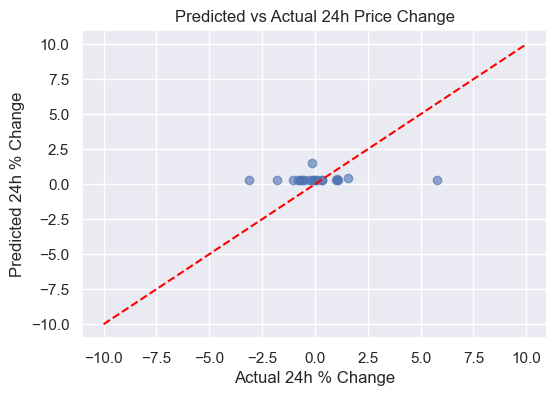

In [4]:
# ============================
# OPTIONAL: SIMPLE ML EXTENSION
# ============================
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Define features (X) and target (y)
X = df[["market_cap", "total_volume"]]
y = df["price_change_percentage_24h"]

# Split data for training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("🔹 Linear Regression Results")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")

# Optional: visualize predicted vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual 24h % Change")
plt.ylabel("Predicted 24h % Change")
plt.title("Predicted vs Actual 24h Price Change")
plt.plot([-10,10],[-10,10], color="red", linestyle="--")  # reference line
plt.show()


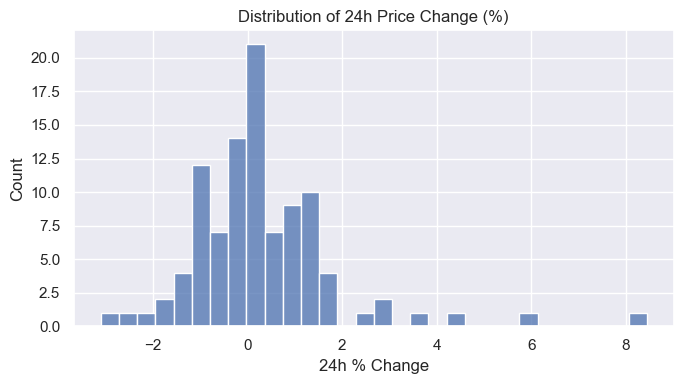

In [5]:
# 1) Histogram: 24h % change
plt.figure(figsize=(7,4))
sns.histplot(df["price_change_percentage_24h"], bins=30)
plt.title("Distribution of 24h Price Change (%)")
plt.xlabel("24h % Change")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("images/plot1_hist.png")
plt.show()

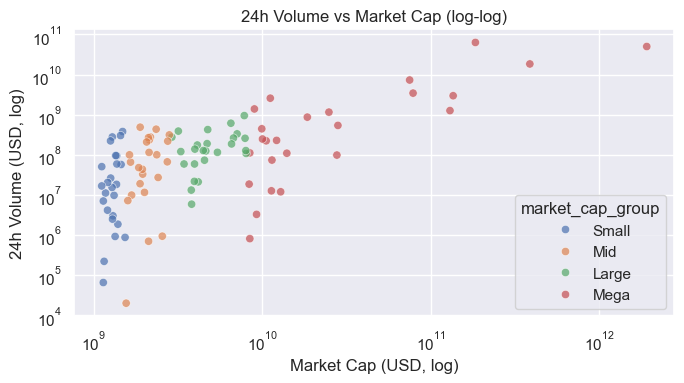

In [6]:
# 2) Scatter: volume vs market cap, colored by cap group
plt.figure(figsize=(7,4))
sns.scatterplot(
    data=df,
    x="market_cap",
    y="total_volume",
    hue="market_cap_group",
    alpha=0.7
)
plt.xscale("log")
plt.yscale("log")
plt.title("24h Volume vs Market Cap (log-log)")
plt.xlabel("Market Cap (USD, log)")
plt.ylabel("24h Volume (USD, log)")
plt.tight_layout()
plt.savefig("images/plot2_scatter.png")
plt.show()


/var/folders/nx/g40gvy41573495fzscz2xs5c0000gn/T/ipykernel_43346/631191154.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("market_cap_group")[["current_price", "volatility_score", "vol_mcap_ratio"]]


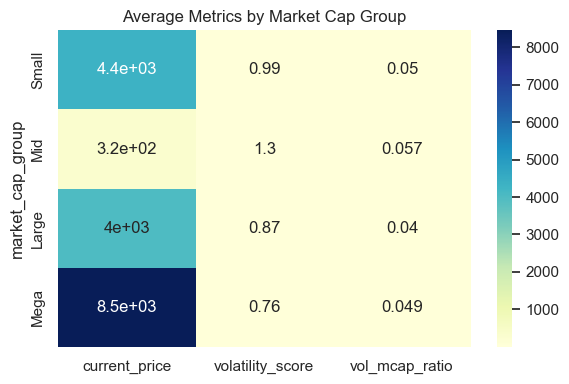

In [7]:
# 3) Heatmap: average metrics by market-cap group
heat = (
    df.groupby("market_cap_group")[["current_price", "volatility_score", "vol_mcap_ratio"]]
      .mean()
      .round(3)
)

plt.figure(figsize=(6,4))
sns.heatmap(heat, annot=True, cmap="YlGnBu")
plt.title("Average Metrics by Market Cap Group")
plt.tight_layout()
plt.savefig("images/plot3_heatmap.png")
plt.show()